<font size="5">Procesar imagenes ABI y seguir un sistema de nubes en el tiempo. Extraer informaciones globales como Areas de lluvia fuerte y débil</font>

### Tormenta a procesar:
Inicio: 13/03/2023 21 UTC

Fin:    14/03/2023 15 UTC

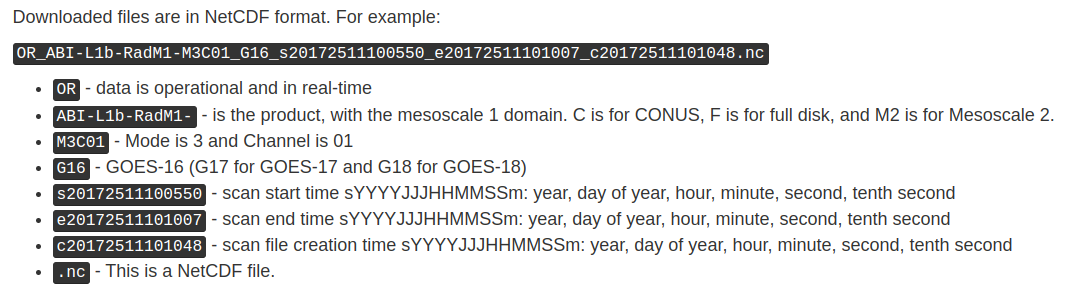

In [436]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
import matplotlib

from netCDF4 import Dataset
import cartopy.crs as ccrs  # Plot maps
import os
import sys

from util_imag_2023 import *


# Función de realce lineal al p porciento
def realce(vec, p=2, gamma=1):
    aux = np.sort(vec.flatten())
    imin = int(len(aux) * p / 100)
    imax = int(len(aux) * (100 - p) / 100)
    vmin = float(aux[imin])
    vmax = float(aux[imax])
    rimag = ( (vec - vmin) / (vmax - vmin) )**gamma
    rimag[rimag < 0] = 0
    rimag[rimag > 1] = 1
    return rimag

def pca(X):
    '''
    Obtiene la descomposición PCA de una imagen de entrada.
    
    Parámetros
    ----------
    X : numpy.array
        Imagen de entrada cuyas dimensiones son [filas, columnas, bandas].
    
    Retornos
    --------
    x_pca : numpy.array
        Array con las componentes principales cuyas dimensiones
        son [filas*columnas, bandas].
    eigen_vals : numpy.array
        Array con los eigen values. 
    eigen_vecs : numpy.array
        Array con los eigen vectors.
    '''
    # Obtenemos las dimensiones
    filas, columnas, bandas = X.shape
    # Reacomodamos la matriz a 2 dimensiones
    xr = np.reshape(X, [filas * columnas, bandas])
    # Centro los datos
    xr = xr - xr.mean(axis=0)
    # Calculamos la matriz de covarianza
    C = np.dot(xr.T, xr) / (filas * columnas - 1)
    # Realizamos la descomposición
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    X_pca = np.dot(xr, eigen_vecs)
    return X_pca, eigen_vals, eigen_vecs



def pca_modificada(X, eigen_vecs):
    '''
    Obtiene la descomposición PCA de una imagen de entrada.
    
    Parámetros
    ----------
    X : numpy.array
        Imagen de entrada cuyas dimensiones son [filas, columnas, bandas].
    eigen_vecs : numpy.array
        Array con los eigen vectors.
    
    Retornos
    --------
    x_pca : numpy.array
        Array con las componentes principales cuyas dimensiones
        son [filas*columnas, bandas].

    '''
    # Obtenemos las dimensiones
    filas, columnas, bandas = X.shape
    # Reacomodamos la matriz a 2 dimensiones
    xr = np.reshape(X, [filas * columnas, bandas])
    # Centro los datos
    xr = xr - xr.mean(axis=0)
    # Calculamos la matriz de covarianza
    #C = np.dot(xr.T, xr) / (filas * columnas - 1)
    # Realizamos la descomposición
    # eigen_vals, eigen_vecs = np.linalg.eig(C)
    X_pca = np.dot(xr, eigen_vecs)
    return X_pca



import matplotlib.colors as mcolors

cmap_data_p = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             #(0.501960813999176, 0.501960813999176, 0.501960813999176),
             #(0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             #(0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             #(0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             #(0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             #(0.4000000059604645, 0.20000000298023224, 0.0)
              ]
cmap_p = mcolors.ListedColormap(cmap_data_p, 'precipitation_p')


import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (1.0, 0.0, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')


bounds = [0,0.1,20,100]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

In [437]:
dir_nc = '/home/msuarez/GOES_16_TF/14032023/'

CH08_list = glob.glob(dir_nc+'CH08/*.nc')
CH08_list.sort()

CH10_list = glob.glob(dir_nc+'CH10/*.nc')
CH10_list.sort()

CH12_list = glob.glob(dir_nc+'CH12/*.nc')
CH12_list.sort()

QPE_list  = glob.glob(dir_nc+'QPE/*.nc')
QPE_list.sort()

In [438]:
CH09_list = glob.glob(dir_nc+'CH09/*.nc')
CH09_list.sort()

CH11_list = glob.glob(dir_nc+'CH11/*.nc')
CH11_list.sort()

CH13_list = glob.glob(dir_nc+'CH13/*.nc')
CH13_list.sort()

CH14_list = glob.glob(dir_nc+'CH14/*.nc')
CH14_list.sort()

CH15_list = glob.glob(dir_nc+'CH15/*.nc')
CH15_list.sort()

CH16_list = glob.glob(dir_nc+'CH16/*.nc')
CH16_list.sort()

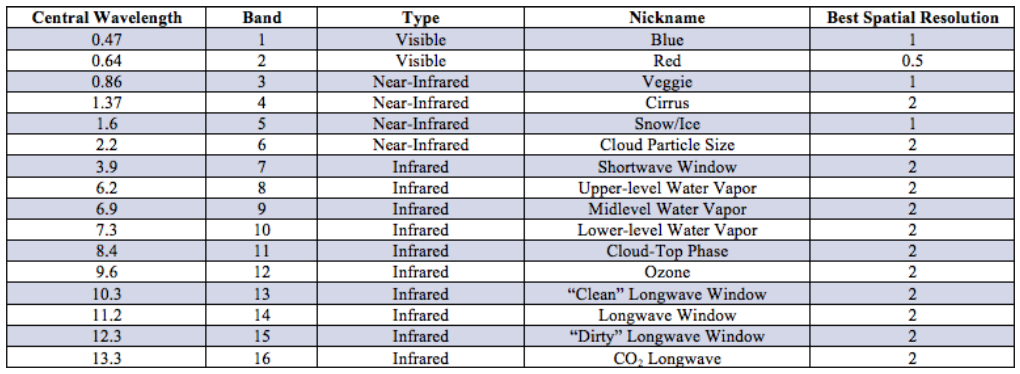

Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
No se recorta imagen
Calibrando la imagen (if)


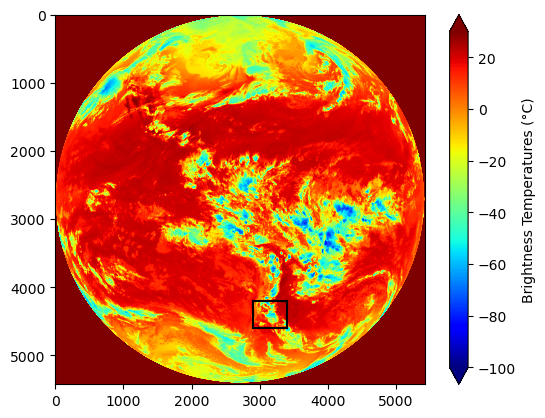

In [439]:
path = '/home/msuarez/GOES_16_TF/14032023/'
img = Dataset(path+'CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc', 'r')

metadato = img.variables

# sup_row = 4200
# inf_row = 4600
# sup_col = 2900
# inf_col = 3300

# CENTRO DE LA ARGENTINA
sup_row = 4200
inf_row = 4600
sup_col = 2900
inf_col = 3400

# True para recortar
recortar = False

# altura de la orbita del satelite en metros (35786023.0)
altura=metadato['goes_imager_projection'].perspective_point_height
# 6378137.0 semieje mayor en metros
semieje_may=metadato['goes_imager_projection'].semi_major_axis
# 6356752.31414 semieje menor en metros
semieje_men=metadato['goes_imager_projection'].semi_minor_axis
# -75 longitud central
lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

#img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

icanal = int(metadato['band_id'][:])
print ('Procesando Canal %d' %icanal)
#print('pol',pol,' ecu',ecu)
####################################################################################################
imagen = metadato['Rad'][:].data
print('Tamaño original de la imagen:',imagen.shape)

if recortar:
    print('Recortando imagen')
    # Bandas de 1 km de resolución espacial
    if (icanal == 1) or (icanal == 3) or (icanal == 5):
        print('entra al if 1,3,5')
        imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
    # Bandas de 0.5 km de resolución espacial
    elif icanal == 2:
        print('entra al elif 2')
        imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
    # Bandas de 2 km de resolución espacial
    else:
        print('entra al else')
        imagen = imagen[sup_row:inf_row,sup_col:inf_col]
else:
    print('No se recorta imagen')
    
    
    
if icanal >7:
    print ('Calibrando la imagen (if)')
    #Parámetros de calibracion
    fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
    fk2 = metadato['planck_fk2'][0] # (=1497.61)
    bc1 = metadato['planck_bc1'][0] # (=0.09102)
    bc2 = metadato['planck_bc2'][0] # (=0.99971)

    imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
    # imag_cal es un array de (5424, 5424)
    Unit = "Temperatura de Brillo [°C]"
else:
    print ('Calibrando la imagen (else)')
    pendiente= metadato['Rad'].scale_factor
    ordenada= metadato['Rad'].add_offset
    imag_cal =imagen*pendiente+ordenada
    Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    
    
img = plt.imshow(imag_cal,vmin=-100,vmax=30, cmap='jet')
plt.plot([sup_col,inf_col],[sup_row,sup_row], color='black')
plt.plot([sup_col,inf_col],[inf_row,inf_row], color='black')
plt.plot([inf_col,inf_col],[inf_row,sup_row], color='black')
plt.plot([sup_col,sup_col],[inf_row,sup_row], color='black')
plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both',
             orientation='vertical',pad=0.05, fraction=0.05)


plt.show()

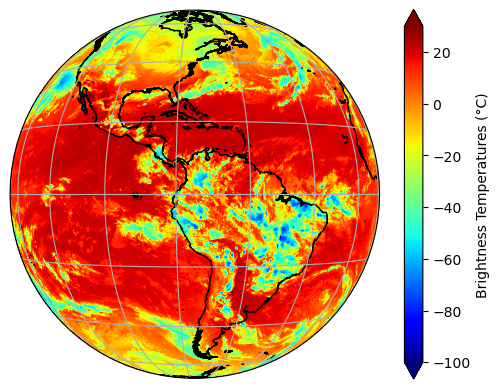

In [440]:
plt.figure()
#proyeccion geoestacionaria para Goes16
crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura)
ax = plt.axes(projection=crs)
ax.gridlines() #agrega linea de meridianos y paralelos
ax.coastlines(resolution='10m',color='black') #agrega líneas de costa

img=plt.imshow(imag_cal,extent=img_extent,vmin=-100.,vmax=30.,cmap='jet')
# Add a colorbar
plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',pad=0.05, fraction=0.05)

plt.show()

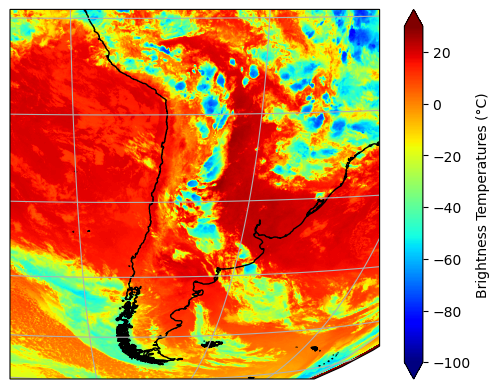

In [441]:
#%% Recortes crudos
psize=2000 # lado de pixel de referencia en m
N=5424 #numero de pixeles de referencia

Nx=2000 #numero de puntos del recorte en x
Ny=2000 #numero de puntos del recorte en x

esc=int(imag_cal.shape[0]/N)

x0=-1200000 # Coordenada x del limite superior izquierdo en m
y0=-1000000 # Coordenada y del limite superior izquierdo en m

f0=int((img_extent[1]-y0)/psize*esc) #fila del angulo superior izquierdo
c0=int((img_extent[3]+x0)/psize*esc) #columna del angulo superior izquierdo
f1=int(f0+Nx*esc) #fila del angulo inferior derecho
c1=int(c0+Ny*esc) #columna del angulo inferior derecho

img_extentr=[x0,x0+Nx*psize*esc,y0-Ny*psize*esc,y0]

indf=range(f0,f1,esc)
indc=range(c0,c1,esc)
# im_rec=imag_cal[:].data[indf,indc]
im_rec=imag_cal[indf[0]:indf[-1],indc[0]:indc[-1]]

# plt.figure()
# img=plt.imshow(im_rec,vmin=-100.,vmax=30.,cmap='jet')
# plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',
#              pad=0.05, fraction=0.05)


#%%

# im_rec=imagedata[f0:f1:esc,c0:c1:esc]
plt.figure()
ax = plt.axes(projection=crs)
ax.gridlines() #agrega linea de meridianos y paralelos
ax.coastlines(resolution='10m',color='black') #agrega líneas de costa

img=plt.imshow(im_rec,transform=crs, extent=img_extentr,vmin=-100.,vmax=30.,cmap='jet')
plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',
             pad=0.05, fraction=0.05)

plt.show()

# Aca se cargan todas las bandas del mismo t

## La función de este bloque es trabajar con las distintas bandas y explorar cuales son mejores para funcionar como mascara lluvia fuerte-debil

In [442]:
h = 3

# list_imgs = [CH08_list[h],CH10_list[h],CH12_list[h]]

list_imgs = [CH08_list[h],CH09_list[h],CH10_list[h],
             CH11_list[h],CH12_list[h],CH13_list[h],
             CH14_list[h],CH15_list[h],CH16_list[h]]

QPE_img = QPE_list[h]

qpe_obj = Dataset(QPE_img, 'r')

imagenobj_list = []

print('Importando imagenes...')
for i in range(len(list_imgs)): imagenobj_list.append(Dataset(list_imgs[i], 'r'))
print('Imagenes importadas en la lista imagenobj_list.')

metadato_list = [imagenobj_list[i].variables for i in range(len(list_imgs))]

# Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
# Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
# respectivamente, de forma tal de obtener el mismo recorte

# RECORTE DE SUDAMERICA
#sup_row = 4000
#inf_row = 5000
#sup_col = 2500
#inf_col = 3600

# CENTRO DE LA ARGENTINA
sup_row = 4200
inf_row = 4600
sup_col = 2900
inf_col = 3400

print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

imagen_list = []
imag_cal_list = []

for metadato in metadato_list:
    
    try:
        # altura de la orbita del satelite en metros (35786023.0)
        altura=metadato['goes_imager_projection'].perspective_point_height
        # 6378137.0 semieje mayor en metros
        semieje_may=metadato['goes_imager_projection'].semi_major_axis
        # 6356752.31414 semieje menor en metros
        semieje_men=metadato['goes_imager_projection'].semi_minor_axis
        # -75 longitud central
        lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

        #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
        img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
        pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
        ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

        icanal = int(metadato['band_id'][:])
        print ('Procesando Canal %d' %icanal)
        #print('pol',pol,' ecu',ecu)
        ####################################################################################################
        imagen = metadato['Rad'][:].data
        print('Tamaño original de la imagen:',imagen.shape)
        print('Recortando imagen')
        # Bandas de 1 km de resolución espacial
        if (icanal == 1) or (icanal == 3) or (icanal == 5):
            print('entra al if 1,3,5')
            imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
        # Bandas de 0.5 km de resolución espacial
        elif icanal == 2:
            print('entra al elif 2')
            imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
        # Bandas de 2 km de resolución espacial
        else:
            print('entra al else')
            imagen = imagen[sup_row:inf_row,sup_col:inf_col]
        ####################################################################################################
        if icanal >7:
            print ('Calibrando la imagen (if)')
            #Parámetros de calibracion
            fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
            fk2 = metadato['planck_fk2'][0] # (=1497.61)
            bc1 = metadato['planck_bc1'][0] # (=0.09102)
            bc2 = metadato['planck_bc2'][0] # (=0.99971)

            imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
            imag_cal_list.append(imag_cal)
            # imag_cal es un array de (5424, 5424)
            Unit = "Temperatura de Brillo [°C]"
        else:
            print ('Calibrando la imagen (else)')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset
            imag_cal =imagen*pendiente+ordenada
            imag_cal_list.append(imag_cal)
            Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    except:
        print('Se ingresó al bloque except!')
        continue
        
    print('\n') 

Importando imagenes...
Imagenes importadas en la lista imagenobj_list.
Tamaño del recorte: Alto= 400  Ancho= 500
Procesando Canal 8
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 9
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 10
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 11
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 12
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 13
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 15
Tamaño o

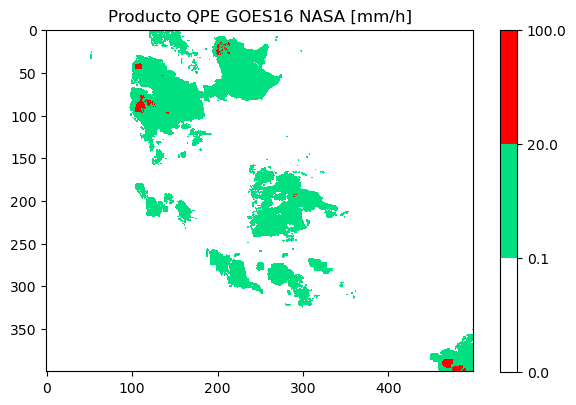

In [443]:
plt.figure(figsize=(6, 6))

plt.subplot(111)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)

plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.title('Producto QPE GOES16 NASA [mm/h]')
plt.tight_layout()
plt.show()

# Siguiente bloque para generar imagenes secuenciales de la tormenta

In [ ]:
import cartopy.feature as cf

ocean = cf.NaturalEarthFeature(
    'physical', 'ocean', scale='50m', 
    edgecolor='none', facecolor=cf.COLORS['water'])

for l in range(len(CH12_list)):
    
    img = Dataset(CH12_list[l], 'r')

    metadato = img.variables

    # altura de la orbita del satelite en metros (35786023.0)
    altura=metadato['goes_imager_projection'].perspective_point_height
    # 6378137.0 semieje mayor en metros
    semieje_may=metadato['goes_imager_projection'].semi_major_axis
    # 6356752.31414 semieje menor en metros
    semieje_men=metadato['goes_imager_projection'].semi_minor_axis
    # -75 longitud central
    lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

    #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
    img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
    pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
    ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

    icanal = int(metadato['band_id'][:])
    print ('Procesando Canal %d' %icanal)
    #print('pol',pol,' ecu',ecu)
    ####################################################################################################
    imagen = metadato['Rad'][:].data   


    if icanal >7:
        print ('Calibrando la imagen (if)')
        #Parámetros de calibracion
        fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
        fk2 = metadato['planck_fk2'][0] # (=1497.61)
        bc1 = metadato['planck_bc1'][0] # (=0.09102)
        bc2 = metadato['planck_bc2'][0] # (=0.99971)

        imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
        # imag_cal es un array de (5424, 5424)
        Unit = "Temperatura de Brillo [°C]"
    else:
        print ('Calibrando la imagen (else)')
        pendiente= metadato['Rad'].scale_factor
        ordenada= metadato['Rad'].add_offset
        imag_cal =imagen*pendiente+ordenada
        Unit = "Radiancia ["+metadato['Rad'].units+"]"  

    #%% Recortes crudos
    psize=2000 # lado de pixel de referencia en m
    N=5424 #numero de pixeles de referencia

    Nx=800 #numero de puntos del recorte en x
    Ny=800 #numero de puntos del recorte en x

    esc=int(1)#int(imag_cal.shape[0]/N)

    x0=10000 # Coordenada x del limite superior izquierdo en m
    y0=-2350000 # Coordenada y del limite superior izquierdo en m

    f0=int((img_extent[1]-y0)/psize*esc) #fila del angulo superior izquierdo
    c0=int((img_extent[3]+x0)/psize*esc) #columna del angulo superior izquierdo
    f1=int(f0+Nx*esc) #fila del angulo inferior derecho
    c1=int(c0+Ny*esc) #columna del angulo inferior derecho

    img_extentr=[x0,x0+Nx*psize*esc,y0-Ny*psize*esc,y0]

    indf=range(f0,f1,esc)
    indc=range(c0,c1,esc)
    # im_rec=imag_cal[:].data[indf,indc]
    im_rec=imag_cal[indf[0]:indf[-1],indc[0]:indc[-1]]

    crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura)
    # im_rec=imagedata[f0:f1:esc,c0:c1:esc]
    plt.figure()
    ax = plt.axes(projection=crs)
    ax.gridlines() #agrega linea de meridianos y paralelos
    ax.coastlines(resolution='10m',color='black') #agrega líneas de costa
    ax.add_feature(ocean) 

    img=plt.imshow(im_rec,transform=crs, extent=img_extentr,vmin=-80.,vmax=-20.,cmap=cmap_p.reversed())
    
    ax.scatter(-64.19052607998151, -31.41072560605113-0.5 , transform=ccrs.PlateCarree(),
               s=100, marker='*', color='black')
    ax.text(-64.19052607998151, -31.41072560605113, 'Córdoba', transform=ccrs.PlateCarree(),
           fontdict={'ha':'center', 'va':'bottom'})
    
    ax.scatter(-58.3909531194226 , -34.614069539608685-0.5, transform=ccrs.PlateCarree(),
               s=100, marker='*', color='black') 
    ax.text(-58.3909531194226 , -34.614069539608685, 'Buenos Aires', transform=ccrs.PlateCarree(),
           fontdict={'ha':'center', 'va':'bottom'}) 
    
    ax.scatter(-70.66934714297933, -33.453471485678264, transform=ccrs.PlateCarree(),
               s=100, marker='*', color='black')
    ax.text(-70.66934714297933, -33.453471485678264-0.5, 'Santiago', transform=ccrs.PlateCarree(),
           fontdict={'ha':'center', 'va':'top'})
    
    plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',
                 pad=0.05, fraction=0.05)

    plt.title(CH12_list[l].split('G16_s')[-1][:4]+'-'+CH12_list[l].split('G16_s')[-1][4:7]+\
'-'+CH12_list[l].split('G16_s')[-1][7:11]+' Z')
    plt.tight_layout()
#     plt.savefig('/home/msuarez/GOES_16_TF/Canal12/Imagen-'+str(l+1)+'.png', dpi=150)
    plt.show()

In [445]:
x_pca_3d_realzada.shape

(400, 500, 3)

# Areas de lluvias intensas

### Recorte 1

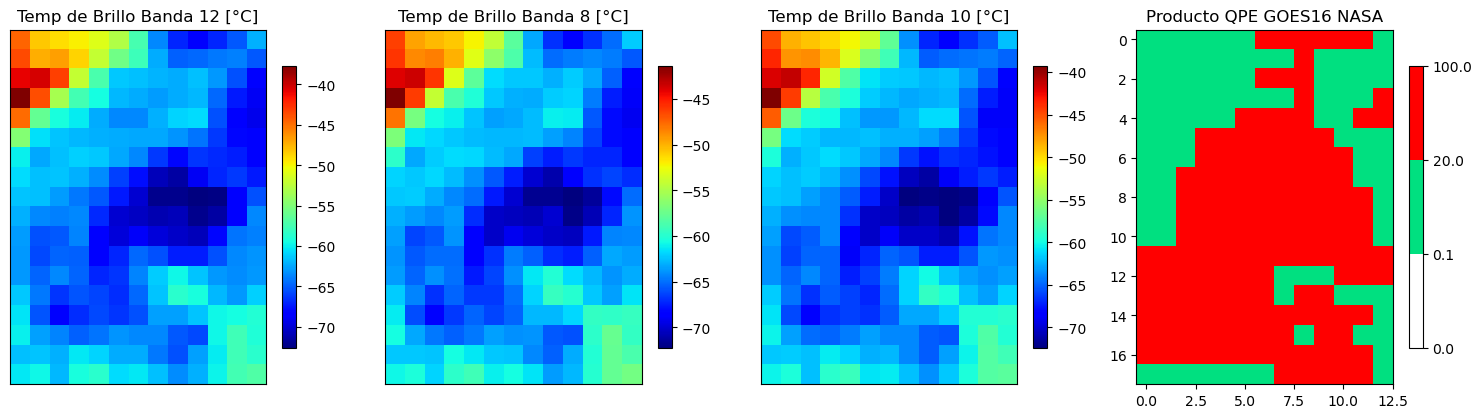

In [446]:
# Recorte de una región de interes
xmin = 104
xmax = 117
ymin = 80
ymax = 98

recorte1_CH08 = imag_cal_list[0][ymin:ymax, xmin:xmax].flatten()
recorte1_CH09 = imag_cal_list[1][ymin:ymax, xmin:xmax].flatten()
recorte1_CH10 = imag_cal_list[2][ymin:ymax, xmin:xmax].flatten()
recorte1_CH11 = imag_cal_list[3][ymin:ymax, xmin:xmax].flatten()
recorte1_CH12 = imag_cal_list[4][ymin:ymax, xmin:xmax].flatten()
recorte1_CH13 = imag_cal_list[5][ymin:ymax, xmin:xmax].flatten()
recorte1_CH14 = imag_cal_list[6][ymin:ymax, xmin:xmax].flatten()
recorte1_CH15 = imag_cal_list[7][ymin:ymax, xmin:xmax].flatten()
recorte1_CH16 = imag_cal_list[8][ymin:ymax, xmin:xmax].flatten()
recorte1_QPE  = qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten()


plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(imag_cal_list[2][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(142)
plt.imshow(imag_cal_list[0][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 8 [°C]")

plt.subplot(143)
plt.imshow(imag_cal_list[1][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 10 [°C]")

# plt.subplot(132)
# plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
# plt.colorbar(shrink=.6)
# plt.title('CP1')

plt.subplot(144)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],cmap=cmap,norm=norm)
plt.title("Producto QPE GOES16 NASA")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.tight_layout()

plt.show()

### Recorte 2

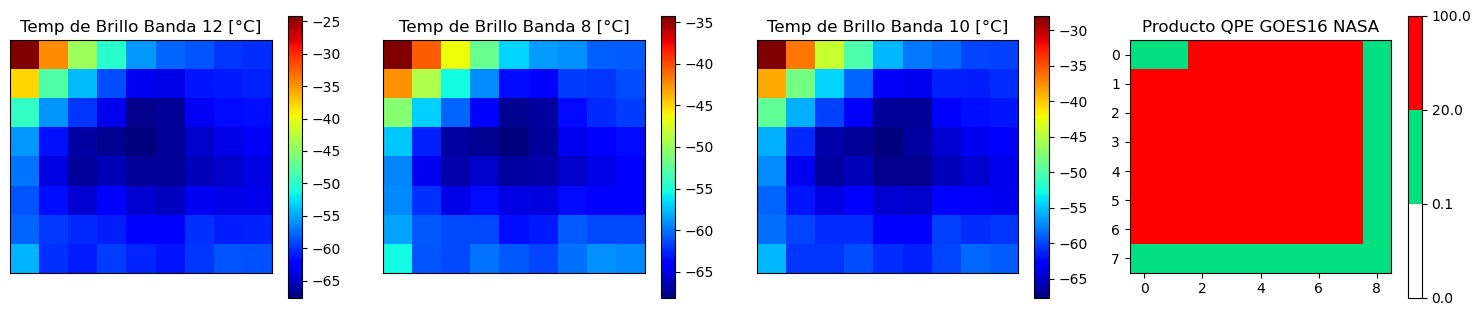

In [447]:
# Recorte de una región de interes
xmin = 104
xmax = 113
ymin = 40
ymax = 48


recorte2_CH08 = imag_cal_list[0][ymin:ymax, xmin:xmax].flatten()
recorte2_CH09 = imag_cal_list[1][ymin:ymax, xmin:xmax].flatten()
recorte2_CH10 = imag_cal_list[2][ymin:ymax, xmin:xmax].flatten()
recorte2_CH11 = imag_cal_list[3][ymin:ymax, xmin:xmax].flatten()
recorte2_CH12 = imag_cal_list[4][ymin:ymax, xmin:xmax].flatten()
recorte2_CH13 = imag_cal_list[5][ymin:ymax, xmin:xmax].flatten()
recorte2_CH14 = imag_cal_list[6][ymin:ymax, xmin:xmax].flatten()
recorte2_CH15 = imag_cal_list[7][ymin:ymax, xmin:xmax].flatten()
recorte2_CH16 = imag_cal_list[8][ymin:ymax, xmin:xmax].flatten()
recorte2_QPE  = qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten()

plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(imag_cal_list[2][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(142)
plt.imshow(imag_cal_list[0][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 8 [°C]")

plt.subplot(143)
plt.imshow(imag_cal_list[1][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 10 [°C]")

# plt.subplot(132)
# plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
# plt.colorbar(shrink=.6)
# plt.title('CP1')

plt.subplot(144)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],cmap=cmap,norm=norm)
plt.title("Producto QPE GOES16 NASA")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.tight_layout()

plt.show()

### Recorte 3

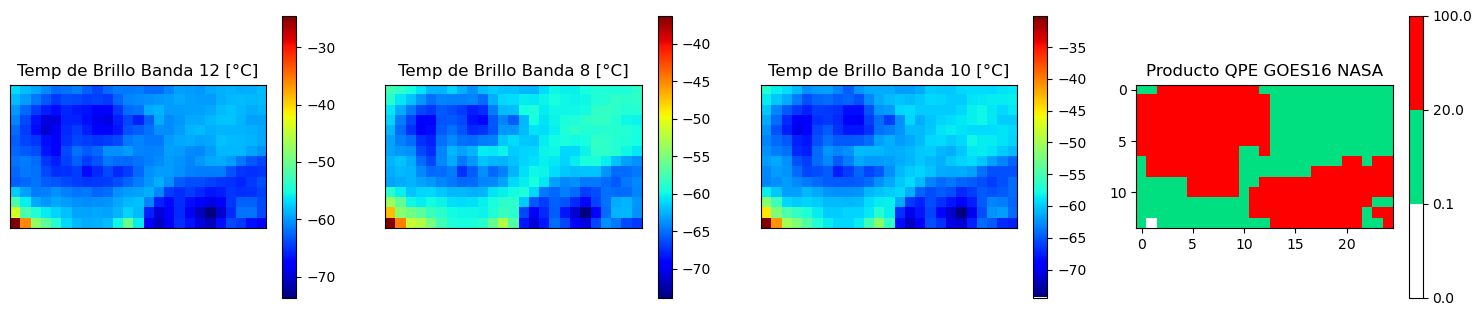

In [448]:
# Recorte de una región de interes
xmin = 464
xmax = 489
ymin = 386
ymax = 400

recorte3_CH08 = imag_cal_list[0][ymin:ymax, xmin:xmax].flatten()
recorte3_CH09 = imag_cal_list[1][ymin:ymax, xmin:xmax].flatten()
recorte3_CH10 = imag_cal_list[2][ymin:ymax, xmin:xmax].flatten()
recorte3_CH11 = imag_cal_list[3][ymin:ymax, xmin:xmax].flatten()
recorte3_CH12 = imag_cal_list[4][ymin:ymax, xmin:xmax].flatten()
recorte3_CH13 = imag_cal_list[5][ymin:ymax, xmin:xmax].flatten()
recorte3_CH14 = imag_cal_list[6][ymin:ymax, xmin:xmax].flatten()
recorte3_CH15 = imag_cal_list[7][ymin:ymax, xmin:xmax].flatten()
recorte3_CH16 = imag_cal_list[8][ymin:ymax, xmin:xmax].flatten()
recorte3_QPE  = qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten()

plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(imag_cal_list[2][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(142)
plt.imshow(imag_cal_list[0][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 8 [°C]")

plt.subplot(143)
plt.imshow(imag_cal_list[1][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 10 [°C]")

# plt.subplot(132)
# plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
# plt.colorbar(shrink=.6)
# plt.title('CP1')

plt.subplot(144)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],cmap=cmap,norm=norm)
plt.title("Producto QPE GOES16 NASA")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.tight_layout()

plt.show()

### Recorte 4

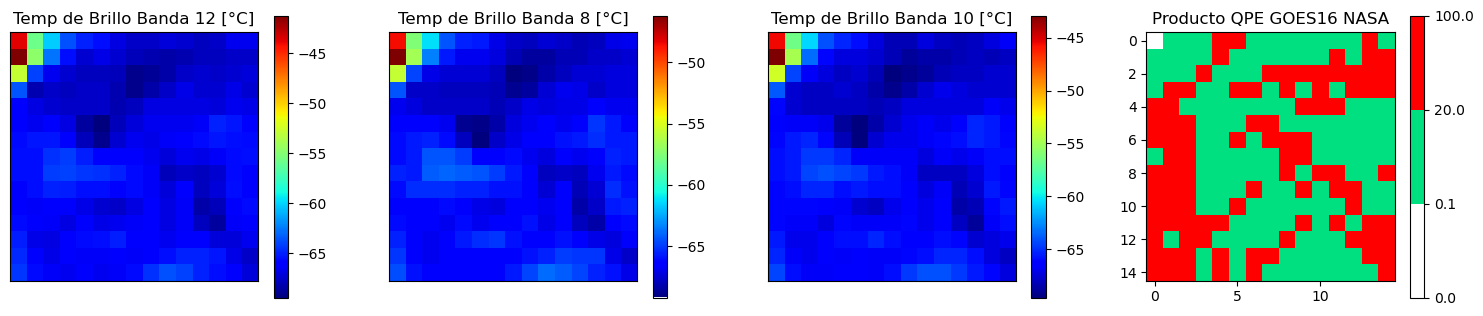

In [449]:
# Recorte de una región de interes
xmin = 200
xmax = 215
ymin = 15
ymax = 30

recorte4_CH08 = imag_cal_list[0][ymin:ymax, xmin:xmax].flatten()
recorte4_CH09 = imag_cal_list[1][ymin:ymax, xmin:xmax].flatten()
recorte4_CH10 = imag_cal_list[2][ymin:ymax, xmin:xmax].flatten()
recorte4_CH11 = imag_cal_list[3][ymin:ymax, xmin:xmax].flatten()
recorte4_CH12 = imag_cal_list[4][ymin:ymax, xmin:xmax].flatten()
recorte4_CH13 = imag_cal_list[5][ymin:ymax, xmin:xmax].flatten()
recorte4_CH14 = imag_cal_list[6][ymin:ymax, xmin:xmax].flatten()
recorte4_CH15 = imag_cal_list[7][ymin:ymax, xmin:xmax].flatten()
recorte4_CH16 = imag_cal_list[8][ymin:ymax, xmin:xmax].flatten()
recorte4_QPE  = qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten()

plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(imag_cal_list[2][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(142)
plt.imshow(imag_cal_list[0][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 8 [°C]")

plt.subplot(143)
plt.imshow(imag_cal_list[1][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 10 [°C]")

# plt.subplot(132)
# plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
# plt.colorbar(shrink=.6)
# plt.title('CP1')

plt.subplot(144)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],cmap=cmap,norm=norm)
plt.title("Producto QPE GOES16 NASA")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.tight_layout()

plt.show()

In [450]:
recorte_lluvia_intensa_CH08 = np.concatenate((recorte1_CH08,recorte2_CH08,recorte3_CH08,recorte4_CH08))
recorte_lluvia_intensa_CH09 = np.concatenate((recorte1_CH09,recorte2_CH09,recorte3_CH09,recorte4_CH09))
recorte_lluvia_intensa_CH10 = np.concatenate((recorte1_CH10,recorte2_CH10,recorte3_CH10,recorte4_CH10))
recorte_lluvia_intensa_CH11 = np.concatenate((recorte1_CH11,recorte2_CH11,recorte3_CH11,recorte4_CH11))
recorte_lluvia_intensa_CH12 = np.concatenate((recorte1_CH12,recorte2_CH12,recorte3_CH12,recorte4_CH12))
recorte_lluvia_intensa_CH13 = np.concatenate((recorte1_CH13,recorte2_CH13,recorte3_CH13,recorte4_CH13))
recorte_lluvia_intensa_CH14 = np.concatenate((recorte1_CH14,recorte2_CH14,recorte3_CH14,recorte4_CH14))
recorte_lluvia_intensa_CH15 = np.concatenate((recorte1_CH15,recorte2_CH15,recorte3_CH15,recorte4_CH15))
recorte_lluvia_intensa_CH16 = np.concatenate((recorte1_CH16,recorte2_CH16,recorte3_CH16,recorte4_CH16))

recorte_lluvia_intensa_QPE = np.concatenate((recorte1_QPE,recorte2_QPE,recorte3_QPE,recorte4_QPE))

In [451]:
recorte_lluvia_intensa_list=[recorte_lluvia_intensa_CH08,recorte_lluvia_intensa_CH09,recorte_lluvia_intensa_CH10,
                             recorte_lluvia_intensa_CH11,recorte_lluvia_intensa_CH12,recorte_lluvia_intensa_CH13,
                             recorte_lluvia_intensa_CH14,recorte_lluvia_intensa_CH15,recorte_lluvia_intensa_CH16]

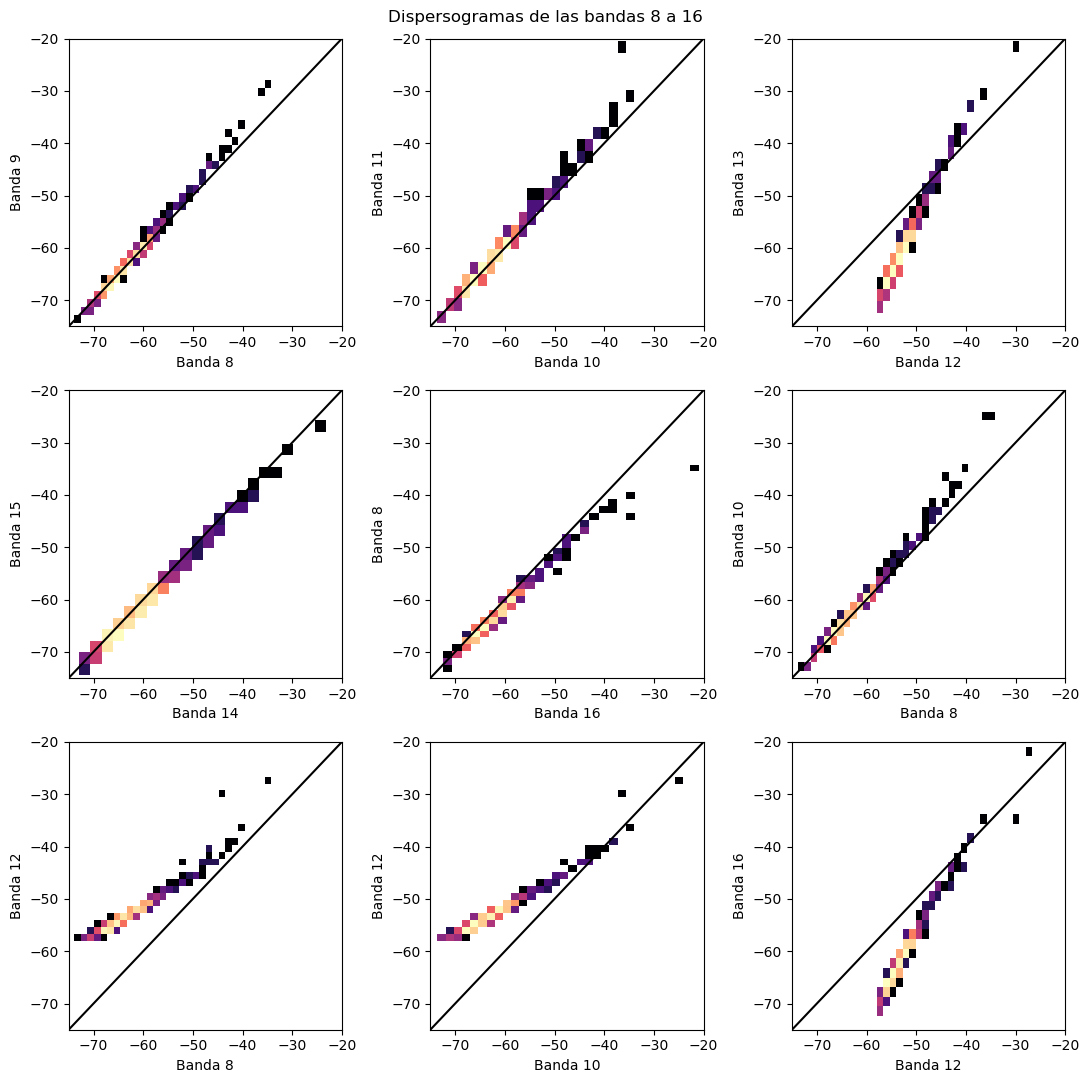

In [452]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
fig = plt.figure(figsize=(11, 11))

bins=30

plt.subplot(3, 3, 1)
plt.hist2d(recorte_lluvia_intensa_CH08,recorte_lluvia_intensa_CH09,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 8'),plt.ylabel('Banda 9'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 2)
plt.hist2d(recorte_lluvia_intensa_CH10,recorte_lluvia_intensa_CH11,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 10'),plt.ylabel('Banda 11'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 3)
plt.hist2d(recorte_lluvia_intensa_CH12,recorte_lluvia_intensa_CH13,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 12'),plt.ylabel('Banda 13'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 4)
plt.hist2d(recorte_lluvia_intensa_CH14,recorte_lluvia_intensa_CH15,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 14'),plt.ylabel('Banda 15'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 5)
plt.hist2d(recorte_lluvia_intensa_CH16,recorte_lluvia_intensa_CH08,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 16'),plt.ylabel('Banda 8'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 6)
plt.hist2d(recorte_lluvia_intensa_CH08,recorte_lluvia_intensa_CH10,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 8'),plt.ylabel('Banda 10'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 7)
plt.hist2d(recorte_lluvia_intensa_CH08,recorte_lluvia_intensa_CH12,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 8'),plt.ylabel('Banda 12'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 8)
plt.hist2d(recorte_lluvia_intensa_CH10,recorte_lluvia_intensa_CH12,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 10'),plt.ylabel('Banda 12'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 9)
plt.hist2d(recorte_lluvia_intensa_CH12,recorte_lluvia_intensa_CH16,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 12'),plt.ylabel('Banda 16'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

fig.suptitle('Dispersogramas de las bandas 8 a 16')
plt.tight_layout()
plt.show()

# De la figura anterior me quedo con las bandas 10, 12 y 16

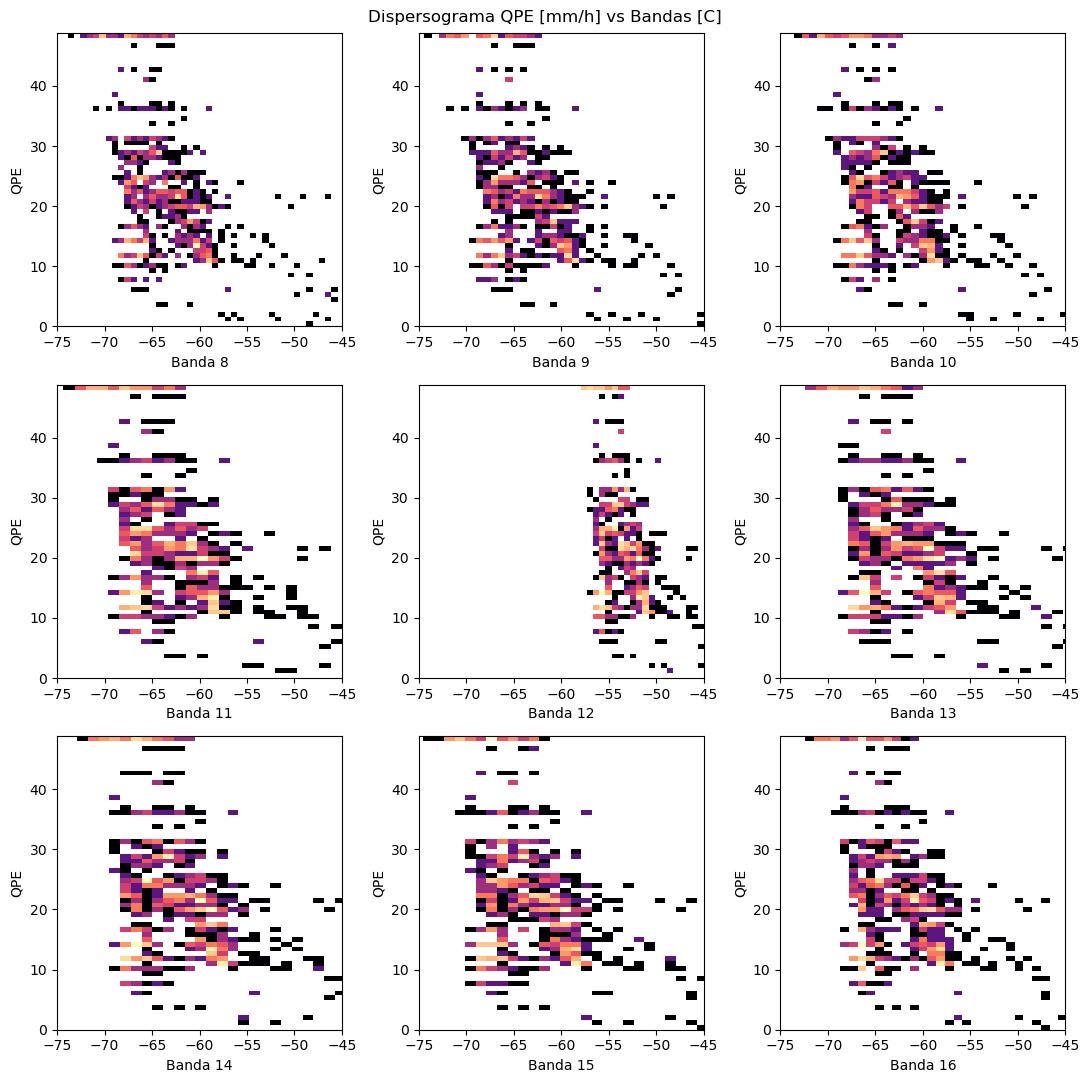

In [453]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
fig, ax = plt.subplots(3,3, figsize=(11, 11))
ax = ax.ravel()

bins=60

i=0

for recorte in recorte_lluvia_intensa_list:
    ax[i].hist2d(recorte,recorte_lluvia_intensa_QPE,bins=bins,norm=lognorm, cmap='magma')
    ax[i].set_xlabel('Banda '+str(i+8))
    ax[i].set_ylabel('QPE')
    ax[i].set_xlim(-75,-45)
    i=i+1

fig.suptitle('Dispersograma QPE [mm/h] vs Bandas [C]')
plt.tight_layout()
plt.show()

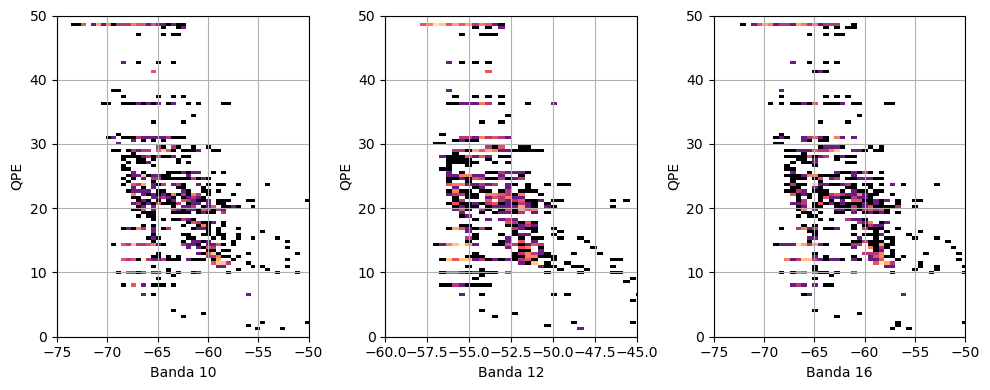

In [454]:
# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
fig = plt.figure(figsize=(10, 4))

bins=100

plt.subplot(1, 3, 1)
plt.hist2d(recorte_lluvia_intensa_CH10,recorte_lluvia_intensa_QPE,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 10'),plt.ylabel('QPE'),plt.xlim(-75,-50),plt.ylim(0,50),plt.grid()

plt.subplot(1, 3, 2)
plt.hist2d(recorte_lluvia_intensa_CH12,recorte_lluvia_intensa_QPE,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 12'),plt.ylabel('QPE'),plt.xlim(-60,-45),plt.ylim(0,50),plt.grid()

plt.subplot(1, 3, 3)
plt.hist2d(recorte_lluvia_intensa_CH16,recorte_lluvia_intensa_QPE,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 16'),plt.ylabel('QPE'),plt.xlim(-75,-50),plt.ylim(0,50),plt.grid()

plt.tight_layout()
plt.show()

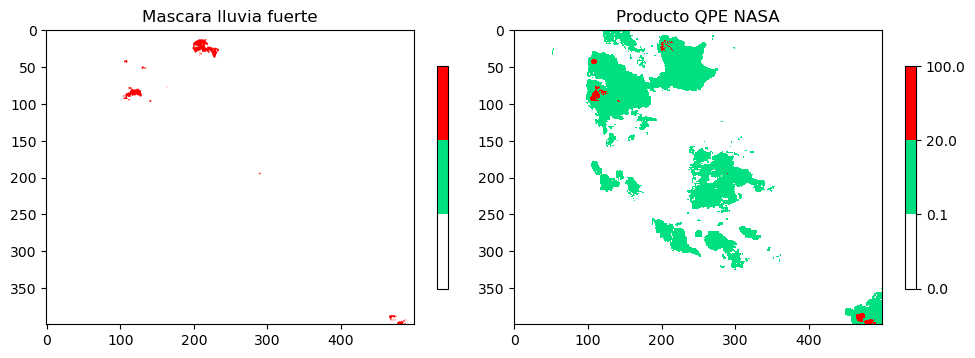

In [455]:
RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

RGBrec[:,:,0] = imag_cal_list[2] # Banda 10
RGBrec[:,:,1] = imag_cal_list[4] # Banda 12
RGBrec[:,:,2] = imag_cal_list[8] # Banda 16

lluvia_intensa1 = (RGBrec[:,:,0] < -65) 
lluvia_intensa2 = (RGBrec[:,:,1] > -57.5) * (RGBrec[:,:,1] < -55) 
lluvia_intensa3 = (RGBrec[:,:,2] < -65) 

img_enmascarada = np.ones_like(RGBrec)

img_enmascarada[lluvia_intensa1,1:3] = 0
img_enmascarada[lluvia_intensa2,1:3] = 0
img_enmascarada[lluvia_intensa3,1:3] = 0

img_enmascarada[lluvia_intensa1,0]   = 1
img_enmascarada[lluvia_intensa2,0]   = 1
img_enmascarada[lluvia_intensa3,0]   = 1
##################################################################################################
plt.figure(figsize=(10, 3.5))

plt.subplot(121)
plt.imshow(img_enmascarada, cmap=cmap)
plt.colorbar(shrink=.7, cmap=cmap, ticks=[]),plt.title('Mascara lluvia fuerte')

plt.subplot(122)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)
plt.title("Producto QPE NASA"),plt.colorbar(shrink=.7, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.tight_layout()
plt.show()

# Areas de lluvias ligeras

### Recorte 1

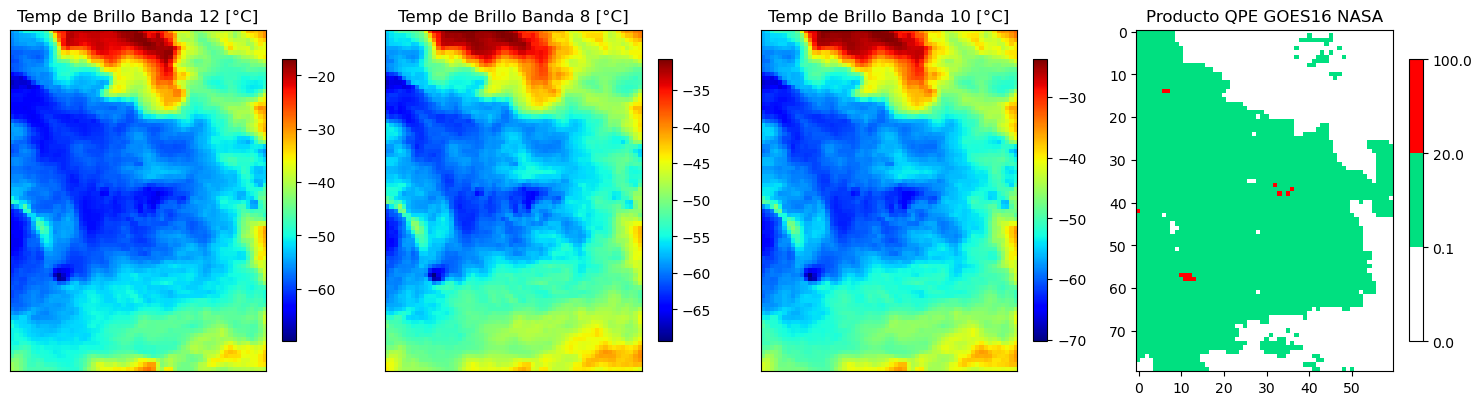

In [456]:
# Recorte de una región de interes
xmin = 130
xmax = 190
ymin = 40
ymax = 120

recorte1_CH08_ll = imag_cal_list[0][ymin:ymax, xmin:xmax].flatten()
recorte1_CH09_ll = imag_cal_list[1][ymin:ymax, xmin:xmax].flatten()
recorte1_CH10_ll = imag_cal_list[2][ymin:ymax, xmin:xmax].flatten()
recorte1_CH11_ll = imag_cal_list[3][ymin:ymax, xmin:xmax].flatten()
recorte1_CH12_ll = imag_cal_list[4][ymin:ymax, xmin:xmax].flatten()
recorte1_CH13_ll = imag_cal_list[5][ymin:ymax, xmin:xmax].flatten()
recorte1_CH14_ll = imag_cal_list[6][ymin:ymax, xmin:xmax].flatten()
recorte1_CH15_ll = imag_cal_list[7][ymin:ymax, xmin:xmax].flatten()
recorte1_CH16_ll = imag_cal_list[8][ymin:ymax, xmin:xmax].flatten()
recorte1_QPE_ll  = qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten()


plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(imag_cal_list[2][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(142)
plt.imshow(imag_cal_list[0][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 8 [°C]")

plt.subplot(143)
plt.imshow(imag_cal_list[1][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 10 [°C]")

# plt.subplot(132)
# plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
# plt.colorbar(shrink=.6)
# plt.title('CP1')

plt.subplot(144)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],cmap=cmap,norm=norm)
plt.title("Producto QPE GOES16 NASA")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.tight_layout()

plt.show()

### Recorte 2

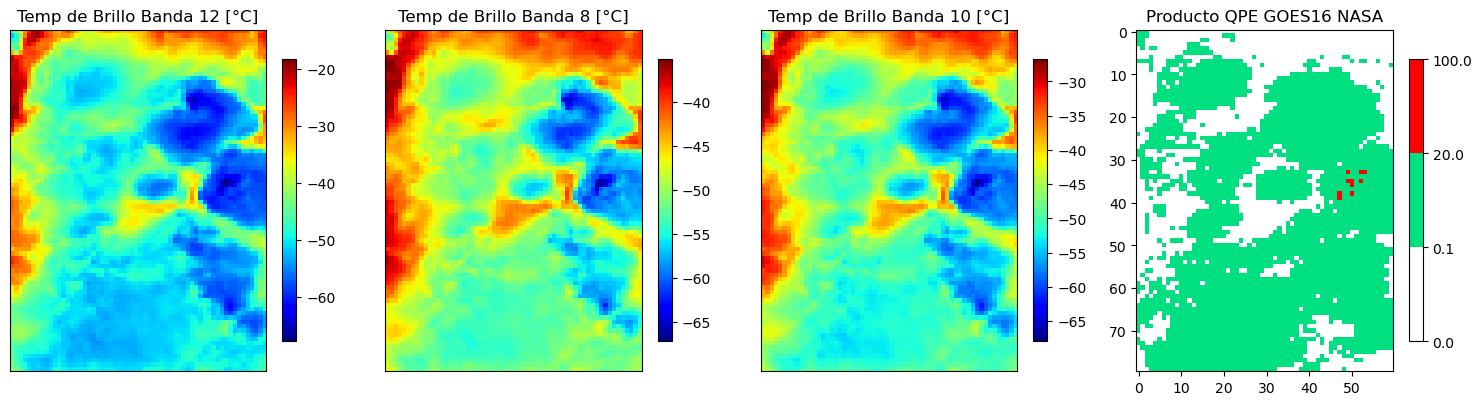

In [457]:
# Recorte de una región de interes
xmin = 240
xmax = 300
ymin = 160
ymax = 240

recorte2_CH08_ll = imag_cal_list[0][ymin:ymax, xmin:xmax].flatten()
recorte2_CH09_ll = imag_cal_list[1][ymin:ymax, xmin:xmax].flatten()
recorte2_CH10_ll = imag_cal_list[2][ymin:ymax, xmin:xmax].flatten()
recorte2_CH11_ll = imag_cal_list[3][ymin:ymax, xmin:xmax].flatten()
recorte2_CH12_ll = imag_cal_list[4][ymin:ymax, xmin:xmax].flatten()
recorte2_CH13_ll = imag_cal_list[5][ymin:ymax, xmin:xmax].flatten()
recorte2_CH14_ll = imag_cal_list[6][ymin:ymax, xmin:xmax].flatten()
recorte2_CH15_ll = imag_cal_list[7][ymin:ymax, xmin:xmax].flatten()
recorte2_CH16_ll = imag_cal_list[8][ymin:ymax, xmin:xmax].flatten()
recorte2_QPE_ll  = qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten()


plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(imag_cal_list[2][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(142)
plt.imshow(imag_cal_list[0][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 8 [°C]")

plt.subplot(143)
plt.imshow(imag_cal_list[1][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 10 [°C]")

# plt.subplot(132)
# plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
# plt.colorbar(shrink=.6)
# plt.title('CP1')

plt.subplot(144)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],cmap=cmap,norm=norm)
plt.title("Producto QPE GOES16 NASA")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.tight_layout()

plt.show()

### Recorte 3

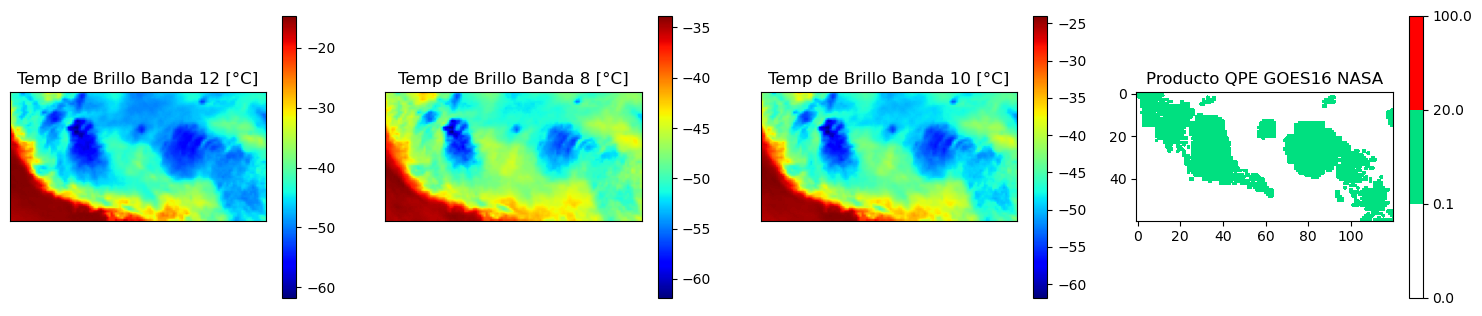

In [458]:
# Recorte de una región de interes
xmin = 190
xmax = 310
ymin = 260
ymax = 320

recorte3_CH08_ll = imag_cal_list[0][ymin:ymax, xmin:xmax].flatten()
recorte3_CH09_ll = imag_cal_list[1][ymin:ymax, xmin:xmax].flatten()
recorte3_CH10_ll = imag_cal_list[2][ymin:ymax, xmin:xmax].flatten()
recorte3_CH11_ll = imag_cal_list[3][ymin:ymax, xmin:xmax].flatten()
recorte3_CH12_ll = imag_cal_list[4][ymin:ymax, xmin:xmax].flatten()
recorte3_CH13_ll = imag_cal_list[5][ymin:ymax, xmin:xmax].flatten()
recorte3_CH14_ll = imag_cal_list[6][ymin:ymax, xmin:xmax].flatten()
recorte3_CH15_ll = imag_cal_list[7][ymin:ymax, xmin:xmax].flatten()
recorte3_CH16_ll = imag_cal_list[8][ymin:ymax, xmin:xmax].flatten()
recorte3_QPE_ll  = qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax].flatten()


plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(imag_cal_list[2][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 12 [°C]")

plt.subplot(142)
plt.imshow(imag_cal_list[0][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 8 [°C]")

plt.subplot(143)
plt.imshow(imag_cal_list[1][ymin:ymax, xmin:xmax], cmap='jet')
plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
plt.colorbar(shrink=.6)
plt.title("Temp de Brillo Banda 10 [°C]")

# plt.subplot(132)
# plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
# plt.colorbar(shrink=.6)
# plt.title('CP1')

plt.subplot(144)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],cmap=cmap,norm=norm)
plt.title("Producto QPE GOES16 NASA")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.tight_layout()

plt.show()

In [459]:
recorte_lluvia_ligera_CH08 = np.concatenate((recorte1_CH08_ll,recorte2_CH08_ll,recorte3_CH08_ll))
recorte_lluvia_ligera_CH09 = np.concatenate((recorte1_CH09_ll,recorte2_CH09_ll,recorte3_CH09_ll))
recorte_lluvia_ligera_CH10 = np.concatenate((recorte1_CH10_ll,recorte2_CH10_ll,recorte3_CH10_ll))
recorte_lluvia_ligera_CH11 = np.concatenate((recorte1_CH11_ll,recorte2_CH11_ll,recorte3_CH11_ll))
recorte_lluvia_ligera_CH12 = np.concatenate((recorte1_CH12_ll,recorte2_CH12_ll,recorte3_CH12_ll))
recorte_lluvia_ligera_CH13 = np.concatenate((recorte1_CH13_ll,recorte2_CH13_ll,recorte3_CH13_ll))
recorte_lluvia_ligera_CH14 = np.concatenate((recorte1_CH14_ll,recorte2_CH14_ll,recorte3_CH14_ll))
recorte_lluvia_ligera_CH15 = np.concatenate((recorte1_CH15_ll,recorte2_CH15_ll,recorte3_CH15_ll))
recorte_lluvia_ligera_CH16 = np.concatenate((recorte1_CH16_ll,recorte2_CH16_ll,recorte3_CH16_ll))

recorte_lluvia_ligera_QPE = np.concatenate((recorte1_QPE_ll,recorte2_QPE_ll,recorte3_QPE_ll))

In [460]:
recorte_lluvia_ligera_list=[recorte_lluvia_ligera_CH08,recorte_lluvia_ligera_CH09,recorte_lluvia_ligera_CH10,
                            recorte_lluvia_ligera_CH11,recorte_lluvia_ligera_CH12,recorte_lluvia_ligera_CH13,
                            recorte_lluvia_ligera_CH14,recorte_lluvia_ligera_CH15,recorte_lluvia_ligera_CH16]

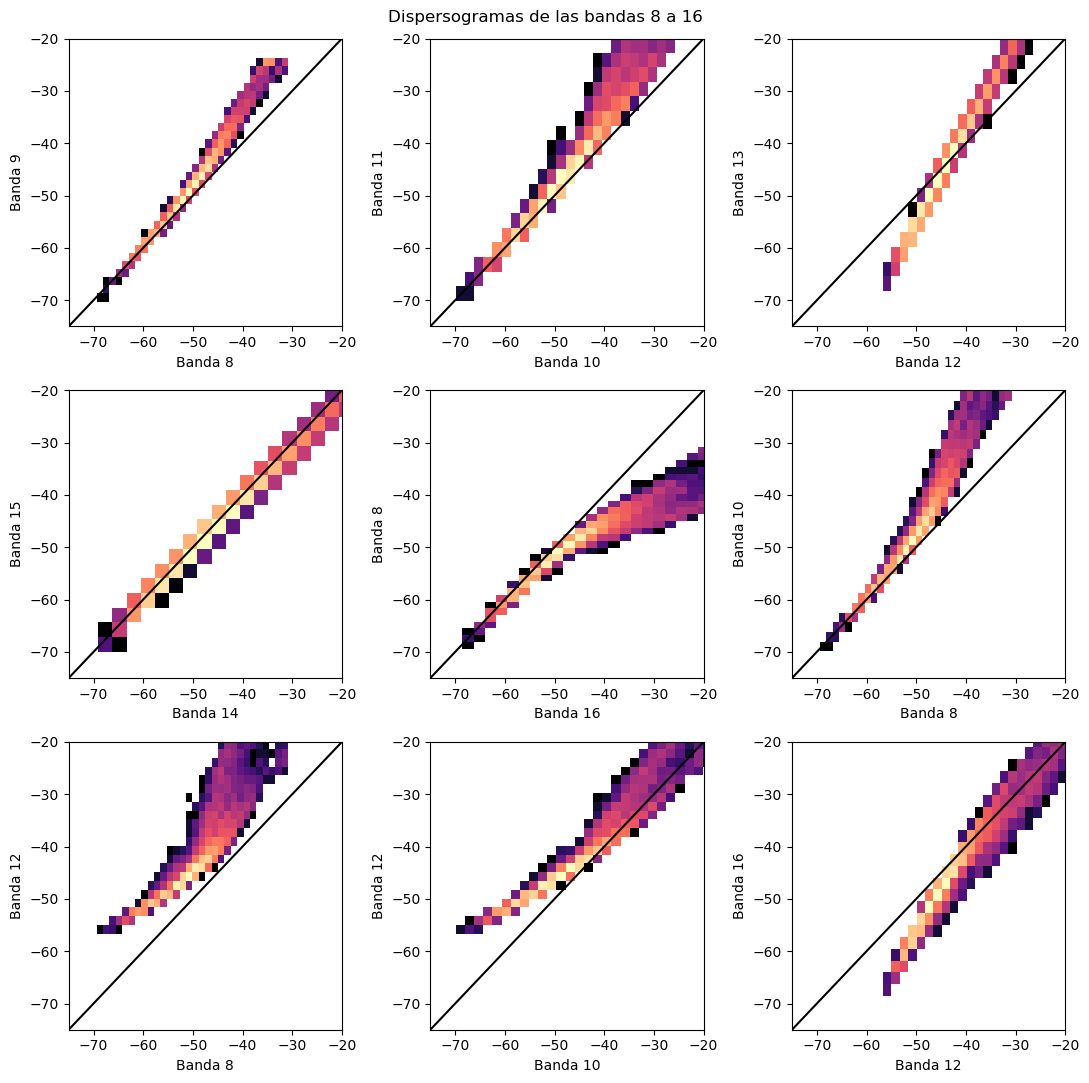

In [461]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
fig = plt.figure(figsize=(11, 11))

bins=30

plt.subplot(3, 3, 1)
plt.hist2d(recorte_lluvia_ligera_CH08,recorte_lluvia_ligera_CH09,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 8'),plt.ylabel('Banda 9'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 2)
plt.hist2d(recorte_lluvia_ligera_CH10,recorte_lluvia_ligera_CH11,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 10'),plt.ylabel('Banda 11'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 3)
plt.hist2d(recorte_lluvia_ligera_CH12,recorte_lluvia_ligera_CH13,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 12'),plt.ylabel('Banda 13'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 4)
plt.hist2d(recorte_lluvia_ligera_CH14,recorte_lluvia_ligera_CH15,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 14'),plt.ylabel('Banda 15'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 5)
plt.hist2d(recorte_lluvia_ligera_CH16,recorte_lluvia_ligera_CH08,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 16'),plt.ylabel('Banda 8'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 6)
plt.hist2d(recorte_lluvia_ligera_CH08,recorte_lluvia_ligera_CH10,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 8'),plt.ylabel('Banda 10'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 7)
plt.hist2d(recorte_lluvia_ligera_CH08,recorte_lluvia_ligera_CH12,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 8'),plt.ylabel('Banda 12'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 8)
plt.hist2d(recorte_lluvia_ligera_CH10,recorte_lluvia_ligera_CH12,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 10'),plt.ylabel('Banda 12'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

plt.subplot(3, 3, 9)
plt.hist2d(recorte_lluvia_ligera_CH12,recorte_lluvia_ligera_CH16,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 12'),plt.ylabel('Banda 16'),plt.axline([0, 0],[1, 1],color='k'),plt.xlim(-75,-20),plt.ylim(-75,-20)

fig.suptitle('Dispersogramas de las bandas 8 a 16')
plt.tight_layout()
plt.show()

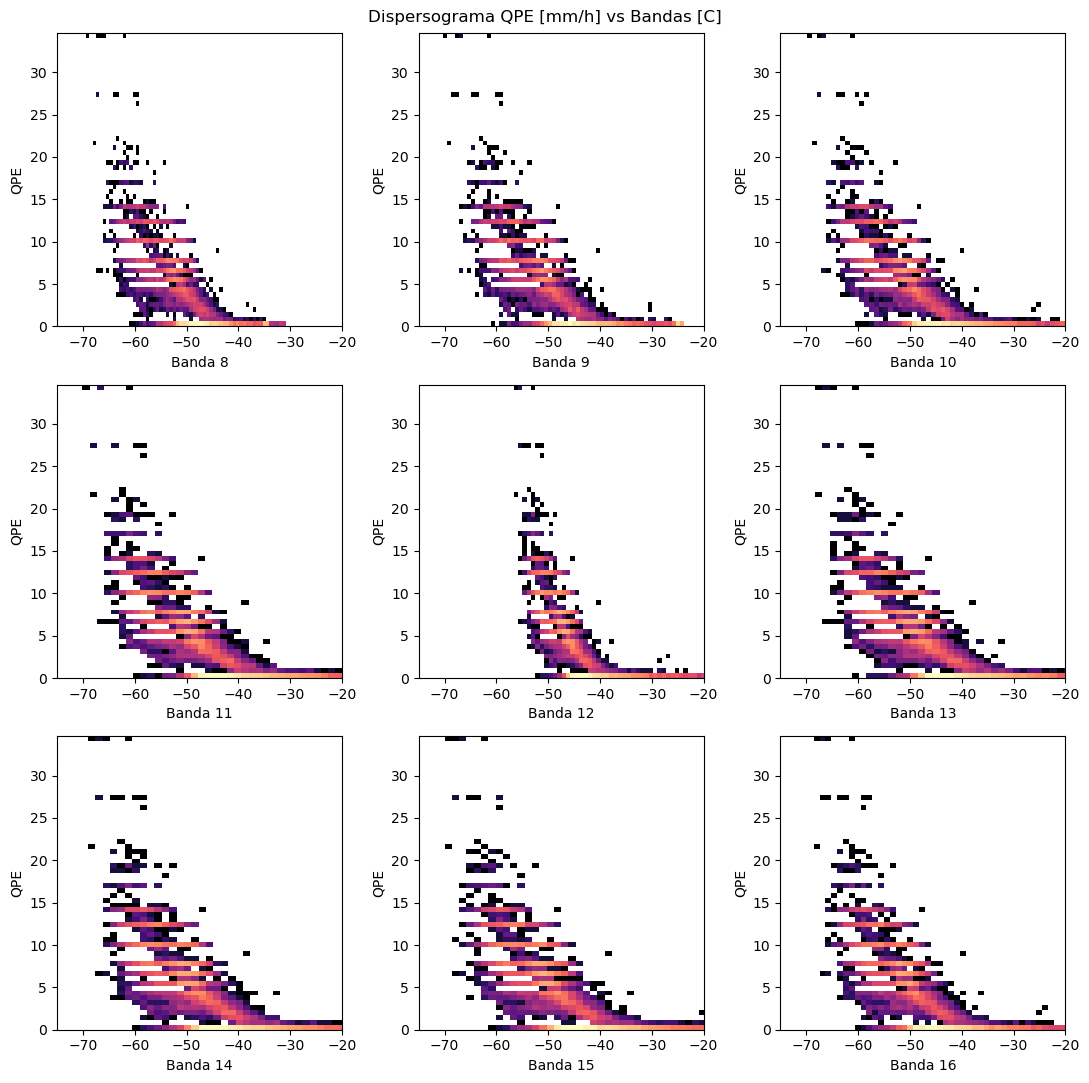

In [462]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
fig, ax = plt.subplots(3,3, figsize=(11, 11))
ax = ax.ravel()

bins=60

i=0

for recorte in recorte_lluvia_ligera_list:
    ax[i].hist2d(recorte,recorte_lluvia_ligera_QPE,bins=bins,norm=lognorm, cmap='magma')
    ax[i].set_xlabel('Banda '+str(i+8))
    ax[i].set_ylabel('QPE')
    ax[i].set_xlim(-75,-20)
    i=i+1

fig.suptitle('Dispersograma QPE [mm/h] vs Bandas [C]')
plt.tight_layout()
plt.show()

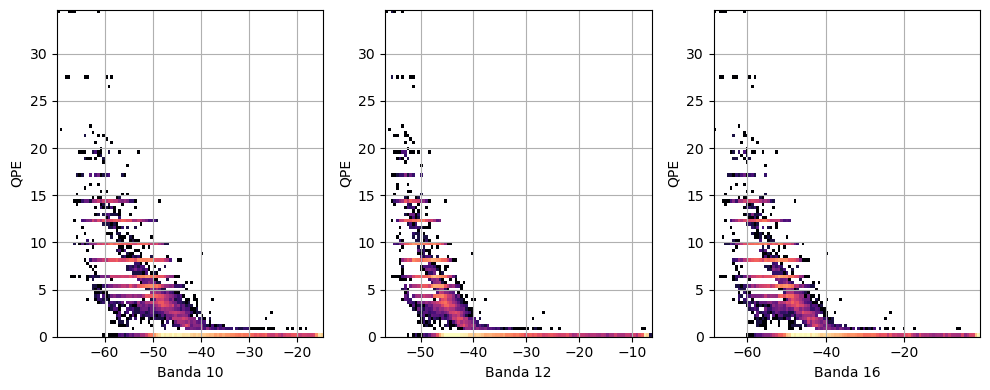

In [463]:
# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
fig = plt.figure(figsize=(10, 4))

bins=100

plt.subplot(1, 3, 1)
plt.hist2d(recorte_lluvia_ligera_CH10,recorte_lluvia_ligera_QPE,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 10'),plt.ylabel('QPE'),plt.grid()

plt.subplot(1, 3, 2)
plt.hist2d(recorte_lluvia_ligera_CH12,recorte_lluvia_ligera_QPE,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 12'),plt.ylabel('QPE'),plt.grid()

plt.subplot(1, 3, 3)
plt.hist2d(recorte_lluvia_ligera_CH16,recorte_lluvia_ligera_QPE,bins=bins,norm=lognorm, cmap='magma')
plt.xlabel('Banda 16'),plt.ylabel('QPE'),plt.grid()

plt.tight_layout()
plt.show()

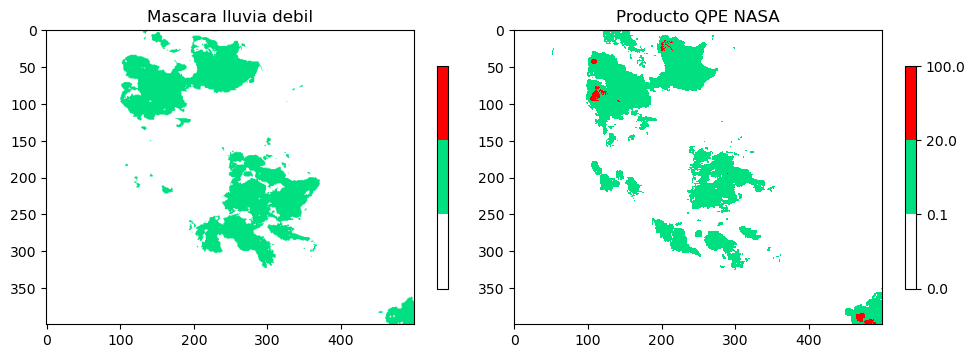

In [464]:
RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

RGBrec[:,:,0] = imag_cal_list[2] # Banda 10
RGBrec[:,:,1] = imag_cal_list[4] # Banda 12
RGBrec[:,:,2] = imag_cal_list[8] # Banda 16

lluvia_ligera1 = (RGBrec[:,:,0] >= -65) * (RGBrec[:,:,0] < -45) 
lluvia_ligera2 = (RGBrec[:,:,1] >= -55) * (RGBrec[:,:,1] < -45) 
lluvia_ligera3 = (RGBrec[:,:,2] >= -65) * (RGBrec[:,:,2] < -45) 

img_enmascarada = np.ones_like(RGBrec)

img_enmascarada[lluvia_ligera1,0] = 0
img_enmascarada[lluvia_ligera1,2] = 0.501960813999176
img_enmascarada[lluvia_ligera1,1] = 0.8784313797950745

img_enmascarada[lluvia_ligera2,0] = 0
img_enmascarada[lluvia_ligera2,2] = 0.501960813999176
img_enmascarada[lluvia_ligera2,1] = 0.8784313797950745

img_enmascarada[lluvia_ligera3,0] = 0
img_enmascarada[lluvia_ligera3,2] = 0.501960813999176
img_enmascarada[lluvia_ligera3,1] = 0.8784313797950745
##################################################################################################
plt.figure(figsize=(10, 3.5))

plt.subplot(121)
plt.imshow(img_enmascarada, cmap=cmap)
plt.colorbar(shrink=.7, cmap=cmap, ticks=[]),plt.title('Mascara lluvia debil')

plt.subplot(122)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)
plt.title("Producto QPE NASA"),plt.colorbar(shrink=.7, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.tight_layout()
plt.show()

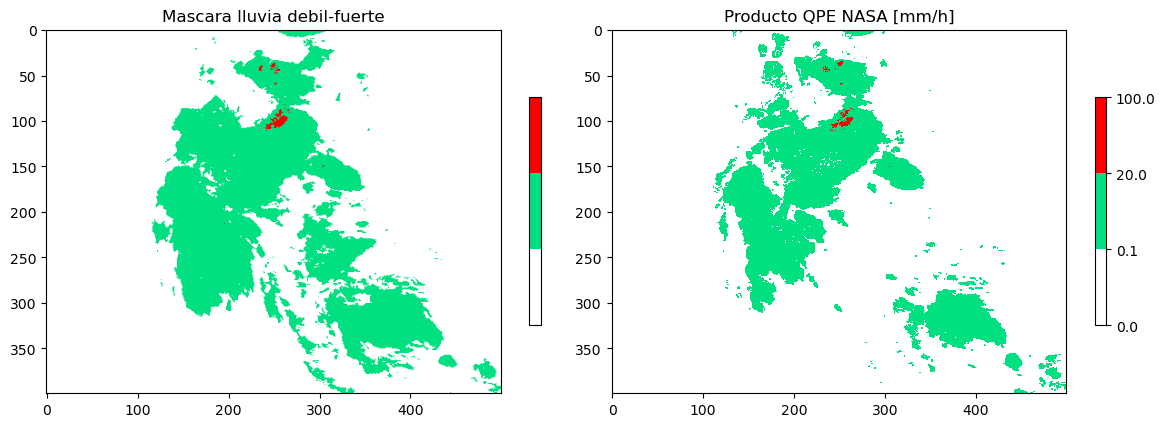

In [468]:
RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

RGBrec[:,:,0] = imag_cal_list[2] # Banda 10
RGBrec[:,:,1] = imag_cal_list[4] # Banda 12
RGBrec[:,:,2] = imag_cal_list[8] # Banda 16

img_enmascarada = np.ones_like(RGBrec)

img_enmascarada[lluvia_ligera1,0] = 0
img_enmascarada[lluvia_ligera1,2] = 0.501960813999176
img_enmascarada[lluvia_ligera1,1] = 0.8784313797950745

img_enmascarada[lluvia_ligera2,0] = 0
img_enmascarada[lluvia_ligera2,2] = 0.501960813999176
img_enmascarada[lluvia_ligera2,1] = 0.8784313797950745

img_enmascarada[lluvia_ligera3,0] = 0
img_enmascarada[lluvia_ligera3,2] = 0.501960813999176
img_enmascarada[lluvia_ligera3,1] = 0.8784313797950745

img_enmascarada[lluvia_intensa1,1:3] = 0
img_enmascarada[lluvia_intensa2,1:3] = 0
img_enmascarada[lluvia_intensa3,1:3] = 0

img_enmascarada[lluvia_intensa1,0]   = 1
img_enmascarada[lluvia_intensa2,0]   = 1
img_enmascarada[lluvia_intensa3,0]   = 1
##################################################################################################
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img_enmascarada, cmap=cmap)
plt.colorbar(shrink=.4, cmap=cmap, ticks=[]),plt.title('Mascara lluvia debil-fuerte')

plt.subplot(122)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)
plt.title("Producto QPE NASA [mm/h]"),plt.colorbar(shrink=.4, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.tight_layout()
plt.show()

In [ ]:
total_rojos_mask = 0
total_verdes_mask = 0

total_rojos_obs = 0
total_verdes_obs = 0

for h in range(len(CH08_list)):
    
    list_imgs_loop = [CH10_list[h],CH12_list[h],CH16_list[h]]
    
    qpe_obj = Dataset(QPE_list[h], 'r')
    
    print('Procesando ', CH10_list[h])
    print('Procesando ', CH12_list[h])
    print('Procesando ', CH16_list[h])
    print('Procesando ', QPE_list[h])
                      
    imagenobj_list_loop = []

    for i in range(len(list_imgs_loop)): imagenobj_list_loop.append(Dataset(list_imgs_loop[i], 'r'))

    metadato_list_loop = [imagenobj_list_loop[i].variables for i in range(len(list_imgs_loop))]

    # Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
    # Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
    # respectivamente, de forma tal de obtener el mismo recorte

    # CENTRO DE LA ARGENTINA
    sup_row = 4200
    inf_row = 4600
    sup_col = 2900
    inf_col = 3400

    imagen_list_loop = []
    imag_cal_list_loop = []

    for metadato in metadato_list_loop:

        try:
            # altura de la orbita del satelite en metros (35786023.0)
            altura=metadato['goes_imager_projection'].perspective_point_height
            # 6378137.0 semieje mayor en metros
            semieje_may=metadato['goes_imager_projection'].semi_major_axis
            # 6356752.31414 semieje menor en metros
            semieje_men=metadato['goes_imager_projection'].semi_minor_axis
            # -75 longitud central
            lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

            #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
            img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
            pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
            ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

            icanal = int(metadato['band_id'][:])
            ####################################################################################################
            imagen = metadato['Rad'][:].data
            imagen_list_loop.append(imagen)

            # Bandas de 1 km de resolución espacial
            if (icanal == 1) or (icanal == 3) or (icanal == 5):
                imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
            # Bandas de 0.5 km de resolución espacial
            elif icanal == 2:
                imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
            # Bandas de 2 km de resolución espacial
            else:
                imagen = imagen[sup_row:inf_row,sup_col:inf_col]
            ####################################################################################################
            if icanal >7:
                #Parámetros de calibracion
                fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
                fk2 = metadato['planck_fk2'][0] # (=1497.61)
                bc1 = metadato['planck_bc1'][0] # (=0.09102)
                bc2 = metadato['planck_bc2'][0] # (=0.99971)

                imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
                imag_cal_list_loop.append(imag_cal)
                # imag_cal es un array de (5424, 5424)
                Unit = "Temperatura de Brillo [°C]"
            else:
                pendiente= metadato['Rad'].scale_factor
                ordenada= metadato['Rad'].add_offset
                imag_cal =imagen*pendiente+ordenada
                imag_cal_list_loop.append(imag_cal)
                Unit = "Radiancia ["+metadato['Rad'].units+"]"  
        except:
            print('Se ingresó al bloque except!')
            continue

        print('\n') 

    RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

    RGBrec[:, :, 0] = imag_cal_list_loop[0]
    RGBrec[:, :, 1] = imag_cal_list_loop[1]
    RGBrec[:, :, 2] = imag_cal_list_loop[2]
    
    lluvia_intensa1 = (RGBrec[:,:,0] < -65) 
    lluvia_intensa2 = (RGBrec[:,:,1] > -57.5) * (RGBrec[:,:,1] < -55) 
    lluvia_intensa3 = (RGBrec[:,:,2] < -65) 
    lluvia_ligera1  = (RGBrec[:,:,0] >= -65) * (RGBrec[:,:,0] < -45) 
    lluvia_ligera2  = (RGBrec[:,:,1] >= -55) * (RGBrec[:,:,1] < -45) 
    lluvia_ligera3  = (RGBrec[:,:,2] >= -65) * (RGBrec[:,:,2] < -45) 
    
    img_enmascarada = np.ones_like(RGBrec)

    img_enmascarada[lluvia_ligera1,0] = 0
    img_enmascarada[lluvia_ligera1,2] = 0.501960813999176
    img_enmascarada[lluvia_ligera1,1] = 0.8784313797950745

    img_enmascarada[lluvia_ligera2,0] = 0
    img_enmascarada[lluvia_ligera2,2] = 0.501960813999176
    img_enmascarada[lluvia_ligera2,1] = 0.8784313797950745

    img_enmascarada[lluvia_ligera3,0] = 0
    img_enmascarada[lluvia_ligera3,2] = 0.501960813999176
    img_enmascarada[lluvia_ligera3,1] = 0.8784313797950745

    img_enmascarada[lluvia_intensa1,1:3] = 0
    img_enmascarada[lluvia_intensa2,1:3] = 0
    img_enmascarada[lluvia_intensa3,1:3] = 0

    img_enmascarada[lluvia_intensa1,0]   = 1
    img_enmascarada[lluvia_intensa2,0]   = 1
    img_enmascarada[lluvia_intensa3,0]   = 1
    ##################################################################################################
    # Conteo de pixeles rojos, verdes y blancos
    valores, cantidad = np.unique(img_enmascarada[:,:,2], return_counts=True)
    rojos_mask, verdes_mask, blancos_mask = cantidad
    
    arr_qpe = qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col]

    verdes_obs = arr_qpe [(arr_qpe>0.1) & (arr_qpe<=20)].shape[0]
    rojos_obs  = arr_qpe [arr_qpe>20].shape[0]
    
    total_rojos_mask  = total_rojos_mask  + rojos_mask
    total_verdes_mask = total_verdes_mask + verdes_mask
    total_rojos_obs   = total_rojos_obs   + rojos_obs
    total_verdes_obs  = total_verdes_obs  + verdes_obs
    
    print('rojos: '+str(rojos)+' verdes: '+str(verdes)+' blancos: '+str(blancos))
    print('rojos obs: '+str(rojos_obs)+' verdes obs: '+str(verdes_obs))
    ##################################################################################################

    plt.figure(figsize=(13, 3.5))

    plt.subplot(131)
    img = plt.imshow(img_enmascarada, cmap)
    cbar = plt.colorbar(img, ticks=[0.15, 0.5, 0.9], shrink=.8, cmap=cmap)
    cbar.ax.set_yticklabels(['Sin lluvia','Lluvia débil', 'Lluvia fuerte'],
                            fontdict={'rotation':90, 'va':'center'})  # vertically oriented colorbar
    plt.title('Mascara lluvia debil-fuerte')
    plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 

    plt.subplot(132)
    plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
               cmap=cmap, norm=norm)
    plt.title("Producto QPE GOES16 NASA [mm/h]")
    plt.colorbar(shrink=.8, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
    plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
    
    plt.text(220, 450, CH12_list[h].split('G16_s')[-1][7:11]+' Z', fontdict={'fontsize':18})
    
    plt.subplot(133)
    plt.imshow(arr_qpe, cmap=cmap_p, vmin=0, vmax=100)
    plt.title("Producto QPE GOES16 NASA [mm/h]")
    plt.colorbar(shrink=.8, cmap=cmap_p)
    plt.tick_params(axis='both', bottom=False,left=False,labelleft=False, labelbottom=False) 
    
    plt.tight_layout()
#     plt.savefig('/home/msuarez/GOES_16_TF/Mascara/Figura-RGB-'+str(h)+'.png', dpi=150)
    plt.show()
    
    
print('total_rojos_mask:',total_rojos_mask)
print('total_verdes_mask:',total_verdes_mask)
print('total_rojos_obs:',total_rojos_obs)
print('total_verdes_obs:',total_verdes_obs)

## Inicio 0000 Z
## Fin 0630 Z

#### total_rojos_mask: 3566
#### total_verdes_mask: 454457
#### total_rojos_obs: 3090
#### total_verdes_obs: 328364

In [512]:
total_pixeles = arr_qpe.shape[0]*arr_qpe.shape[1]*14
total_pixeles

2800000

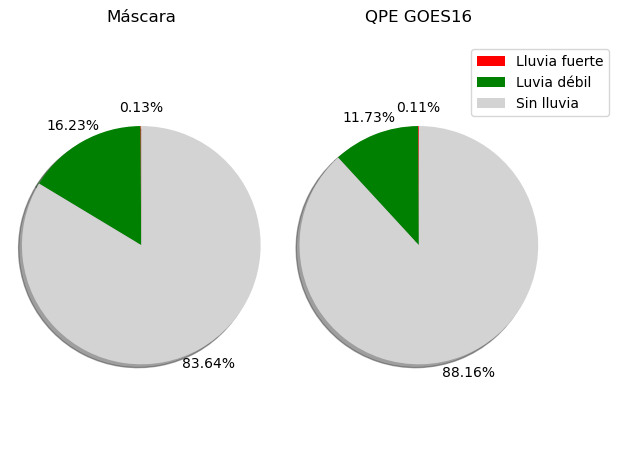

In [578]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Lluvia fuerte', 'Luvia débil', 'Sin lluvia'
sizes_mask = [3566, 454457, total_pixeles-(3566+454457)]
sizes_obs  = [3090, 328364, total_pixeles-(3090+328364)]
explode = (0.25, 0.5, 0.25)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ( "red", "green", "lightgray")

fig1, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizes_mask, autopct='%1.2f%%',
        shadow=True, startangle=90, colors=colors,pctdistance=1.15)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Máscara')

ax2.pie(sizes_obs, autopct='%1.2f%%',
        shadow=True, startangle=90,colors=colors,pctdistance=1.15)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('QPE GOES16')
ax2.legend(labels,loc=(.7,0.8))

plt.tight_layout()
plt.show()

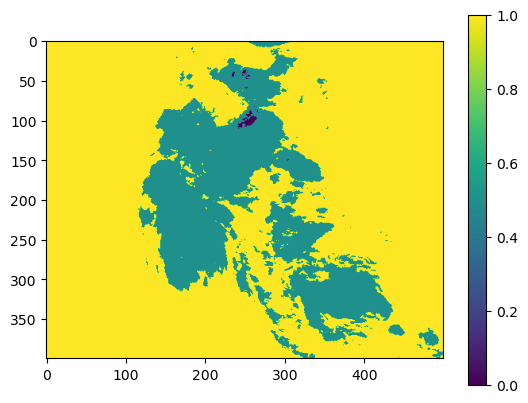

In [479]:
plt.imshow(img_enmascarada[:,:,2])
plt.colorbar()
plt.show()

valores, cantidad = np.unique(img_enmascarada[:,:,2], return_counts=True)
rojos, verdes, blancos = cantidad
rojos, verdes, blancos